In [1]:
from FastFitClassifier import FastFitClassifier
import pandas as pd
from tqdm.auto import tqdm

tqdm.pandas()

In [2]:
DEV = True
model_path = "./models/relevance/avsolatorio/GIST-small-Embedding-v0"



if not DEV:
    model_path = './models/relevance/avsolatorio/GIST-Embedding-v0'

In [3]:
def import_labelled_data(path="data/level-0.5/data.json"):
    data = pd.read_json(path, encoding="latin-1")
    return data



print("Loading data...")

test_dataset = import_labelled_data(path="../../../data/level-0.5/irrelevant.json", )

print("Data loaded.")

if DEV:
    test_dataset = test_dataset.sample(5000)

test_dataset = test_dataset.sample(frac=1).reset_index(drop=True)


test_dataset.info()

Loading data...
Data loaded.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   url           5000 non-null   object
 1   text          5000 non-null   object
 2   relevance     5000 non-null   object
 3   multiclasses  5000 non-null   object
dtypes: object(4)
memory usage: 156.4+ KB


In [4]:
test_dataset.head()

,url,text,relevance,multiclasses
0,https://gcg.gov.ph/files/0zpWcX7MgM5HMBp3Hazs.pdf,PARTIES: THE with G-OVERNMENT GOOD ON COMMISSI...,irrelevant,[]
1,https://documents1.worldbank.org/curated/en/09...,d e z i r o h t u A e r u s o l c s i D c i l ...,irrelevant,[]
2,https://www.wseas.org/multimedia/books/2008/is...,"NEW ASPECTS OF AUTOMATIC CONTROL, MODELLING AN...",irrelevant,[]
3,https://ddjudge.com/assets/normal-probability-...,"Normal Probability Distribution Notes Aka, the...",irrelevant,[]
4,http://archive.xbrl.org/25th/sites/25thconfere...,INSR7: Data Standards and Insurance Supervisio...,irrelevant,[]


In [5]:
import torch
torch.cuda.empty_cache()

In [6]:
classifier = FastFitClassifier(
    model_path=model_path,
    text_overlap_proportion=0.2,
    device='cuda:0'
)

Loading model from ./models/relevance/avsolatorio/GIST-small-Embedding-v0 ...
Model loaded.
Tokenizer loaded....


The model 'FastFit' is not supported for text-classification. Supported models are ['AlbertForSequenceClassification', 'BartForSequenceClassification', 'BertForSequenceClassification', 'BigBirdForSequenceClassification', 'BigBirdPegasusForSequenceClassification', 'BioGptForSequenceClassification', 'BloomForSequenceClassification', 'CamembertForSequenceClassification', 'CanineForSequenceClassification', 'LlamaForSequenceClassification', 'ConvBertForSequenceClassification', 'CTRLForSequenceClassification', 'Data2VecTextForSequenceClassification', 'DebertaForSequenceClassification', 'DebertaV2ForSequenceClassification', 'DistilBertForSequenceClassification', 'ElectraForSequenceClassification', 'ErnieForSequenceClassification', 'ErnieMForSequenceClassification', 'EsmForSequenceClassification', 'FalconForSequenceClassification', 'FlaubertForSequenceClassification', 'FNetForSequenceClassification', 'FunnelForSequenceClassification', 'GemmaForSequenceClassification', 'Gemma2ForSequenceClassif


Classifier pipeline built.


#### Profiling Section

In [7]:
!pip install line_profiler
%load_ext line_profiler

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com

[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [8]:
from transformers.pipelines.pt_utils import KeyDataset
from datasets import Dataset
print("Chunking data...", end="\r")
from chunking import chunk_dataset_and_explode

data = test_dataset.sample(100)

chunked_data = chunk_dataset_and_explode(
    data, max_len=512, overlap=int(512 * 0.2)
)

# get dict of chunk_ids to counts of that id so we can track when we've finished all chunks for a file
chunk_id_counts = chunked_data["chunk_id"].value_counts().to_dict()

print("Data chunked.")

chunked_dataset = Dataset.from_pandas(chunked_data)

print("Predicting...", end="\r")

%lprun -u 1e-3 -f FastFitClassifier.predict_chunks classifier.predict_chunks(KeyDataset(chunked_dataset,'text'),chunk_id_counts, chunked_data['chunk_id'])

  0%|          | 0/100 [00:00<?, ?it/s]

Data chunked.


Files	:   0%|          | 0/100 [00:00<?, ?it/s]

Chunks	:   0%|          | 0/24801 [00:00<?, ?it/s]

Calculated predictions.


Timer unit: 0.001 s

Total time: 41.1477 s
File: /GreyLitDocker/GreyLiteratureClassifier/src/FastFit/level-1/FastFitClassifier.py
Function: predict_chunks at line 51

Line #      Hits         Time  Per Hit   % Time  Line Contents
    51                                               def predict_chunks(self, chunked_text, chunk_id_counts,chunk_ids):
    52         1          0.0      0.0      0.0          predictions = []
    53         1          0.0      0.0      0.0          scores = []
    54                                           
    55         1          0.0      0.0      0.0          i = 0
    56                                           
    57         1          0.1      0.1      0.0          print("Predicting from chunks...", end="\r")
    58                                           
    59         2         30.9     15.5      0.1          with tqdm(total=len(chunk_id_counts),desc='Files\t') as files_pbar:
    60         2         29.4     14.7      0.1              with t

##### End Profiling

  0%|          | 0/5000 [00:00<?, ?it/s]

Data chunked.


Files	:   0%|          | 0/5000 [00:00<?, ?it/s]

Chunks	:   0%|          | 0/1495450 [00:00<?, ?it/s]

Calculated predictions.
Evaluating model...

-----------------------------------------------------



/root/.local/share/virtualenvs/GreyLiteratureClassifier-eJH_GeT1/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/.local/share/virtualenvs/GreyLiteratureClassifier-eJH_GeT1/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/.local/share/virtualenvs/GreyLiteratureClassifier-eJH_GeT1/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control

Classification Report: 
              precision    recall  f1-score   support

  irrelevant       1.00      0.96      0.98      5000
    relevant       0.00      0.00      0.00         0

    accuracy                           0.96      5000
   macro avg       0.50      0.48      0.49      5000
weighted avg       1.00      0.96      0.98      5000

-----------------------------------------------------
Accuracy: 0.9576
Precision: 0.5
Specificity: 0.9576


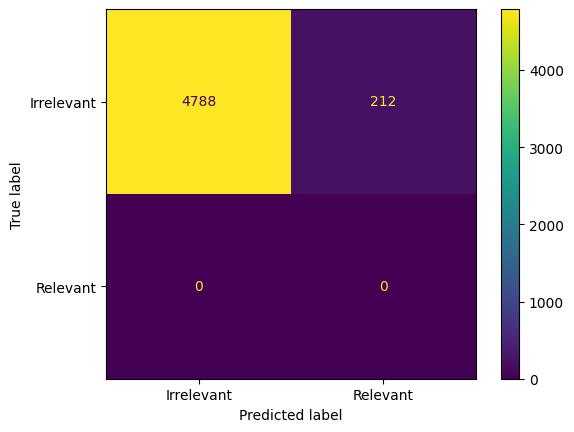

In [9]:

#! on fastfit/modeling.py, line 838, inserting **kwargs
#! it's easier than getting the tokenizer to stop outputting
#! extra info like token_type_ids

predicted_data = classifier.evaluate(
    test_dataset,
    metrics=[
        "accuracy",
        "precision",
        "classification-report",
        "specificity",
        "confusion-matrix-mpl",
    ],
    aggregate="majority",
)

In [10]:
potential = predicted_data[predicted_data["predictions"] == "relevant"]
potential = potential.sort_values(by="score-lv1", ascending=False)


In [11]:
potential = potential[potential['text'].apply(lambda x: x!='No summary for this intervention.')]
potential = potential[potential['score-lv1'].apply(lambda x: x>=0.95)].reset_index(drop=True)

In [12]:
# get max min range of score
max_score = potential['score-lv1'].max()
min_score = potential['score-lv1'].min()
print(f"Max score: {max_score}")
print(f"Min score: {min_score}")



Max score: 1.0
Min score: 0.950026695217405


In [15]:
with pd.option_context('display.max_colwidth', 400):
    display(potential.head(10))

,url,text,relevance,multiclasses,predictions,score-lv1
0,https://www.wyomingwildsheep.org/wp-content/uploads/2022/02/TX-Desert-BHS-Restoration.pdf,"R ESTORATION AND R ESTORATION AND MANAGEMENT OF D ESERT MANAGEMENT OF D ESERT B IGHORN S HEEP IN T EXAS B IGHORN S HEEP IN T EXAS By Froylan Hernandez, Louis A. Harveson, By Froylan Hernandez, Louis A. Harveson, Thomas S. Janke, Reagan T. Gage, Clay E. Brewer, Thomas S. Janke, Reagan T. Gage, Clay E. Brewer, Justin Foster, and Shawn Locke Justin Foster, and Shawn Locke A BRIEF HISTORY OF TEXAS...",irrelevant,[],relevant,1.0
1,https://yosemite.org/wp-content/uploads/2020/04/yosemite-conservancy-honey-bee-coloring-sheet.pdf,"HONEY BEE (Scientific name: Apis) Bees and other pollinators play an important role in ecosystems. As they collect nectar and pollen from flowers, they help plants reproduce. Many of the foods we eat depend on pollinators! You can help bees, butterflies and other pollinators by planting and protecting native flowers in your area. . Illustration by Lora Spielman Visit us online: yosemite.org",irrelevant,[],relevant,1.0
2,https://wtip.org/wp-content/uploads/2022/02/2019-bee-project-handout.pdf,"Wild Bee Surveys in Minnesota February, 2019 Our knowledge of wild bees Wild bees are vital components of Minnesota’s ecosystems by providing essential ecosystem services such as pollination. Although our knowledge of the diversity and distribution of Minnesota’s bees is improving, large gaps still exist. Laying the foundation for bee research Minnesota has an engaged and growing community of ...",irrelevant,[],relevant,1.0
3,https://www.zooreach.org/ZOO_WILD_Activities/2014/FWB/Reptiles-foldout.pdf,"n o i t a The Western Ghats or 'Sahyadris' is home to some very v live up to 100 years, some individuals have been Reptiles, namely snakes, lizards, crocodiles and r 4 5 e s n SCINCIDAE AGAMIDAE Geckoella deccanensis Salea anamallayana o C unique flora, fauna and fungi. The terrestrial ecosystem of | 1 4 recorded to live up to 150 years. India has 28 turtles are cold-blooded animals and their ...",irrelevant,[],relevant,1.0
4,https://files.worldwildlife.org/wwfcmsprod/files/Publication/file/803vp43xa0_PlowprintReport_2020_FINAL_08042020.pdf?_ga=2.242573121.291245891.1635943104-2027897033.1635943104,"PLOW 0 2 0 PRINT 2 orld Wildlife Fund’s 2020 Plowprint Report finds that policies, and a global pandemic has added additional pressures from 2014 to 2018, tillage of grasslands across the to maintaining agricultural livelihoods. The novel coronavirus W Great Plains occurred at an average rate of four foot- has negatively impacted food supply chains and the delivery and ball fields every minute...",irrelevant,[],relevant,1.0
5,https://www.wrisc.org/_files/ugd/b37ba2_4ec05a3b8c524530993feba2ed05d339.pdf,"Wild Rivers Invasive Species Coalition WILD RIVERS ISC December 2023 Issue 26 2023 Accomplishments! • • • • • • Round Leaf Bittersweet: Leaves can be highly variable in shape and come to a point (left), Berries are red with bright yellow fruit capsules that remain on throughout the winter (right) Recognizing Local Populations of Round-leaf Bittersweet American Bittersweet —a native alternative...",irrelevant,[],relevant,1.0
6,https://yearofthesalmon.org/wp-content/uploads/2022/12/63-Potential-factors-influencing-variation-David_Scott.pdf,"Potential factors influencing variation in freshwater and estuarine growth rates of juvenile Chinook salmon in the Fraser River, B.C. David Scott, Misty MacDuffee, Lia Chalifour, Scott G. Hinch th IYS Symposium October 5 , 2022 Acknowledgments Raincoast Conserva.on Founda.on Misty MacDuﬀee and the rest of the team Fisheries and Oceans Canada Murray Manson, Eric Rondeau, Terry Beacham, Suzanne ...",irrelevant,[],relevant,1.0
7,https://www.zooreach.org/ZOO_WILD_Activities/2014/FWB/Aquatic-plants-foldout.pdf,n o i t a v r e s Non Flowering Plants - Algae n o Flowering Plants - Dicotyledons C | n Azolla pinnata o i t a c u Azollaceae (Salviniaceae) d E | 

In [13]:

if DEV:
    from os import makedirs, path
    if not path.exists("../../../data/level-1.5/potential/dev"):
        makedirs("../../../data/level-1.5/potential/dev")
    potential.to_json("../../../data/level-1.5/potential/dev/data.json", orient="records", indent=4)
else:
    potential.to_json("../../../data/level-1.5/potential/data.json", orient="records", indent=4)